In [1]:
# Setup : import some libraries
import pathlib
import glob
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [2]:
#import and preprocess data

training_data_path = 'train'

Tdata_path = pathlib.Path(training_data_path)

#glob calss return a list of all images 

training_folders = list(glob.glob(os.path.join(pathlib.Path(training_data_path), '*')))

training_images = list(pathlib.Path(Tdata_path).glob('*/*.png')) 

In [3]:
# 80% of the images for training
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    Tdata_path,
    validation_split= 0.8,
    subset="training",
    seed= 256,
    image_size=(64,64),
    batch_size=32)

# 20% for validation
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    Tdata_path,
    validation_split= 0.2,
    subset="validation",
    seed= 256,
    image_size=(64,64),
    batch_size=32)

Found 4750 files belonging to 12 classes.
Using 950 files for training.
Found 4750 files belonging to 12 classes.
Using 950 files for validation.


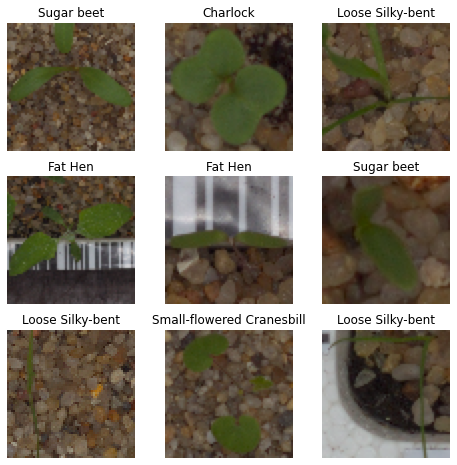

In [4]:
#Show the first 9 images from the training dataset.
species_names = training_dataset.class_names
plt.figure(figsize=(8, 8))
for images, names in training_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(species_names[names[i]])
    plt.axis("off")

In [5]:
# Disrupt and repeat, to avoid impact in training
AUTOTUNE = tf.data.AUTOTUNE
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

#rescale the values to be in the range [0, 1]
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64,64))]

In [6]:
#construct a CNN model : several convolutional layers interspersed with pooling layers
my_model = tf.keras.models.Sequential()

# Input layer
my_model.add(tf.keras.layers.InputLayer(input_shape=(64,64,3,))) 
my_model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) # 2D Convolution layer
 # Max Pooling layer for decreasing the computational power required
my_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
# Normalization layer for standardizing the inputs
my_model.add(tf.keras.layers.BatchNormalization()) 
my_model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))
my_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) 
my_model.add(tf.keras.layers.BatchNormalization())
my_model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))
my_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) 
my_model.add(tf.keras.layers.BatchNormalization())
my_model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) 
my_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))  
 # Global Max Pooling for vertical line detection.
my_model.add(tf.keras.layers.GlobalMaxPool2D())
 # Flatten serves as a connection between the convolution and dense layers.
my_model.add(tf.keras.layers.Flatten())
my_model.add(tf.keras.layers.Dense(128, activation='relu'))
 # Dropout layer helps prevent overfitting
my_model.add(tf.keras.layers.Dropout(0.2))
my_model.add(tf.keras.layers.Dense(64, activation='relu'))
my_model.add(tf.keras.layers.BatchNormalization()) 
 #Output Layer
my_model.add(tf.keras.layers.Dense(12, activation='softmax'))

In [7]:
# compile model
my_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [8]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       7

In [9]:
# fit model
#learning_times = 3 #epochs
learning_times = 20
# against overfitting,set the training to stop when it detects that validation loss is no longer improving.
stop_training = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

training_history = my_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = learning_times,
    verbose="auto",
    callbacks = stop_training
    )


Epoch 1/20
30/30 [==============================] - 15s 337ms/step - loss: 2.5718 - accuracy: 0.1842 - val_loss: 7.2728 - val_accuracy: 0.0842
Epoch 2/20
30/30 [==============================] - 6s 186ms/step - loss: 1.8791 - accuracy: 0.3621 - val_loss: 3.6922 - val_accuracy: 0.1463
Epoch 3/20
30/30 [==============================] - 7s 232ms/step - loss: 1.5622 - accuracy: 0.4695 - val_loss: 2.5421 - val_accuracy: 0.2095
Epoch 4/20
30/30 [==============================] - 6s 209ms/step - loss: 1.3405 - accuracy: 0.5611 - val_loss: 2.0646 - val_accuracy: 0.3263
Epoch 5/20
30/30 [==============================] - 7s 230ms/step - loss: 1.0875 - accuracy: 0.6453 - val_loss: 1.9607 - val_accuracy: 0.3295
Epoch 6/20
30/30 [==============================] - 6s 212ms/step - loss: 0.8842 - accuracy: 0.7179 - val_loss: 1.5987 - val_accuracy: 0.4789
Epoch 7/20
30/30 [==============================] - 7s 218ms/step - loss: 0.7237 - accuracy: 0.7758 - val_loss: 1.6871 - val_accuracy: 0.4442
Epoch

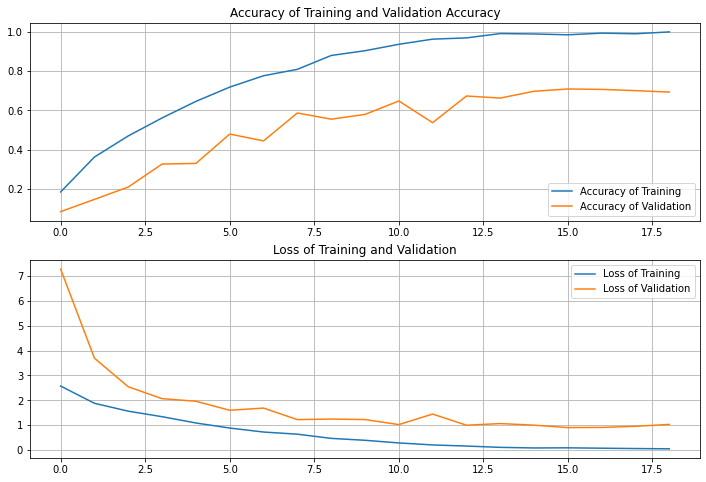

In [10]:
#figure show the result of the model
Loss = training_history.history['loss']
Accuracy = training_history.history['accuracy']
val_loss = training_history.history['val_loss']
val_accuracy = training_history.history['val_accuracy']

epochs_range = range(len(Accuracy))

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(epochs_range, Accuracy, label='Accuracy of Training')
plt.plot(epochs_range, val_accuracy, label='Accuracy of Validation')
plt.legend(loc='lower right')
plt.title('Accuracy of Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(epochs_range, Loss, label='Loss of Training')
plt.plot(epochs_range, val_loss, label='Loss of Validation')
plt.legend(loc='upper right')
plt.title('Loss of Training and Validation')
plt.grid()
plt.show()

In [11]:
#predict

image_list = []
species_list = []
test_data_path = 'test'
test_data_path=list(pathlib.Path(test_data_path).glob('*.png'))

for p in range(len(test_data_path)-1):
    img = keras.preprocessing.image.load_img(test_data_path[p], target_size=(64, 64))
    test_img_array = keras.preprocessing.image.img_to_array(img)
    test_img_array = tf.expand_dims(test_img_array, 0)
    
     # the model make its predictions based on which option has the highest probability.
    predictions = my_model.predict(test_img_array)
    probabilities = tf.nn.softmax(predictions[0]) 
    species = format(species_names[np.argmax(probabilities)])
    # form data
    image_list.append((str(test_data_path[p]).split('/')[-1]))
    species_list.append(species)
    finally_result = pd.DataFrame({'file':image_list,'species':species_list})
    
finally_result.to_csv("submission.csv",index=False)